# Project - "Finding a good neighborhood for opening a bar in Cologne, Germany"

### Introduction
For this project I collected data of the city of Cologne in Germany in order to give advice to a fictional customer, who wants to open a bar in Cologne and seeks to find an appropriate neighborhood based on specific criteria. The target group of the bar is supposed to be young people (about age 18 to 35). Also it is supposed to be located in an area with many bars in the surrounding and with a high population density. 

My goal is to find the neighborhoods which best fit this criteria. 

In order to run a successful bar the first thing needed are many customers to visit. The rest is up to the good management of the bar. As an estimator for the amount of customers, that visit a bar, I will use the amount of tips, that are listed for each bar in Foursquare. I want to analyze if the chosen criteria are associated with the number of tips for a bar using a correlation analysis. 

### Data Description
I downloaded the data I used for this project from the webpage https://www.offenedaten-koeln.de. Here I found two tables, that are interesting for my research question. One table contains information about age distribution of each neighborhood (https://www.offenedaten-koeln.de/dataset/fdeb99c8-8640-4539-b342-2eeaf06eefc9/resource/3c2bee9a-fc8b-437f-aa18-727e9b8aa5ef#{}). The other table contains information about the density of the population in each neighborhood (https://www.offenedaten-koeln.de/dataset/28b8e786-edde-4744-b245-13439e9c1ed8/resource/eae7348a-309f-4560-9b93-7f8504a9a40e#{}). 

In total there are 86 neighborhoods in cologne. Three neighborhoods were excludes from the analysis, because of missing data for ‚Äúcitizens per square kilometers‚Äù. All three neighborhoods have a small population and a small proportion of young people and would not have been interesting for the analysis. 

To get the longitude and latitude for each neighborhood in cologne I used ‚ÄúNominatim‚Äù as a tool. 

I found the nearby bars/pubs of each neighborhood in Cologne with the Foursquare API. I chose a radius of 650 meters for each neighborhood, since increasing the radius would have led to double hits of bars for the neighborhoods. This way I found 52 bras/pubs located in 18 different neighbourhoods. 

In a last step the Foursquare API was used to find the Tip-Count for each bar. 

### Analysis

##### Neihgborhood  characteristics
It might be interesting for the fictive customer to analyse the neighborhood based on their top listed venues to get a better understanding of each neigborhood. I built a dataframe with the top ten venues for each neighborhood.

##### Correlations:
I calculated the correlation matrix of the following variables
- proportion of young people ("percentage 18-34")
- population density" ("citizens per square kilometers")
- number of bars in the neighborhood("Bar/Pub-Count")
- number of tips for each Bar/Pub ("Tip-Count"). 

There is a significant positive correlation with the Tips-Count for all three Variables:
- "Percentage 18-34": r = 0.48)
- "Citizens per square kilometers": r = 0.51)
- "Bar/Pup-Count": r = 0.55)
- There were also high correlations among the three variables

##### Neighborhood selection
To answer the question, which neighborhood would be best suited to open a bar in Cologne I selected all the neighborhoods that have a high Value for ‚Äúpercentage of young people‚Äù, ‚Äúcitizens per square kilometers‚Äù and "Bar/Pub-Count" (percentile =0.7). This selection can be weighted differently based on the priorities of the fictive costumer. 

### Analysis - Data Preprocessing

importing libraries

In [15]:
import pandas as pd
import numpy as np
import re
from scipy import stats
import geopy
from geopy.geocoders import Nominatim 
import folium 
import requests 
import json
from pandas.io.json import json_normalize 

creating credentials for the foursquare API

In [60]:
CLIENT_ID = ###
CLIENT_SECRET = ### 
VERSION = 20181217 
LIMIT = 100

importing the dataset containing informations about the age distribution 

In [61]:
df_age = pd.read_excel("stadtteile_alter14.xlsx")
#change to anglish column names
df_age.rename(columns={'Stadtteil':'Neighborhood', 'Einwohner insgesamt':'citizens total', '80 und √É¬§lter':'80 and above'}, inplace=True)
#select columns needed
filtered_columns = ['Neighborhood', 'citizens total', '18-20', '21-34']
df_age_f = df_age.loc[:, filtered_columns]
#calculate percentages of the agegroup 18-34
df_age_f["18-34"] = df_age_f["18-20"] + df_age_f["21-34"] 
df_age_f["percentage 18-34"] = df_age_f["18-34"]/ df_age_f["citizens total"] * 100
df_age_f["percentage 18-34"] = df_age_f["percentage 18-34"].round(decimals=2)
df_age_f = df_age_f.drop(['citizens total','18-20','21-34','18-34'], axis=1)

In [62]:
df_age_f.head()

Neighborhood  percentage 18-34
0  Altstadt-S√É¬ºd             35.85
1  Neustadt-S√É¬ºd             38.79
2  Altstadt-Nord             36.32
3  Neustadt-Nord             31.01
4          Deutz             31.98

importing the dataset containing informations about the density of the population

In [63]:
df_dense = pd.read_excel("stadtteile_dichte14.xlsx")
#rename to english column names
df_dense.rename(columns={'Stadtteil':'Neighborhood', 'Einwohner je Quadratkilometer':'citizens per square kilometers'}, inplace=True)
#select columns needed
fil_col = ['Neighborhood', 'citizens per square kilometers']
df_dense_f = df_dense.loc[:, fil_col]
df_dense_f.head()

Neighborhood  citizens per square kilometers
0  Altstadt-S√É¬ºd                           11678
1  Neustadt-S√É¬ºd                           13552
2  Altstadt-Nord                            7287
3  Neustadt-Nord                            8084
4          Deutz                            2892

joining the two datasets

In [64]:
df_koeln = df_age_f.join(df_dense_f.set_index('Neighborhood'), on='Neighborhood')
#change to readable strings
df_koeln["Neighborhood"] = df_koeln.Neighborhood.str.replace("√É¬º", "√º")
df_koeln["Neighborhood"] = df_koeln.Neighborhood.str.replace("√É≈∏", "√ü")
df_koeln["Neighborhood"] = df_koeln.Neighborhood.str.replace("√É¬∂", "√∂") 
df_latlon = df_koeln.dropna()
df_latlon.shape

(83, 3)

### Showing a map of Cologne and its neighborhoods

To get the longitude and latitude for each neighborhood in Cologne I used ‚ÄúNominatim‚Äù as a tool.

In [65]:
#creating columns for lat and lon
df_latlon['lat'] = None
df_latlon['lon'] = None

#getting the latitude and longitude for each neighborhood
from geopy.point import Point
bbox = [Point(50.8304494,6.7725303),Point(51.0849743,7.162028)]

for index, row in df_latlon.iterrows():
    try:
        address = '{}, K√∂ln, Deutschland'.format(row["Neighborhood"])
        geolocator = Nominatim(user_agent="test-app",view_box=bbox,bounded=True) 
        location = geolocator.geocode(address)
        df_latlon.loc[index, "lat"] = location.latitude
        df_latlon.loc[index, "lon"] = location.longitude
    except:
        print(row["Neighborhood"], "None-object has no lat/lon")
df_latlon.head()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Neighborhood  percentage 18-34  citizens per square kilometers      lat  \
0   Altstadt-S√ºd             35.85                         11678.0  50.9292   
1   Neustadt-S√ºd             38.79                         13552.0  50.9266   
2  Altstadt-Nord             36.32                          7287.0  50.9423   
3  Neustadt-Nord             31.01                          8084.0  50.9479   
4          Deutz             31.98                          2892.0  50.9368   

       lon  
0  6.95533  
1  6.94041  
2  6.95319  
3  6.94106  
4  6.97305

In [66]:
#geting lat and lon of Cologne, Germany
address = 'k√∂ln, Deutschland'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_k = location.latitude
longitude_k = location.longitude

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
#creating the map
map_k√∂ln= folium.Map(location=[latitude_k, longitude_k], zoom_start=11)
# adding markers to the map
for lat, lng, label in zip(df_latlon['lat'], df_latlon['lon'], df_latlon['Neighborhood']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_k√∂ln)  
map_k√∂ln

# Getting the nearby venues of Cologne's neighborhoods

I found the nearby venues of each neighborhood in Cologne with the Foursquare API. I chose a radius of 650 meters for each neighborhood, since increasing the radius led to double hits for found bars/pubs. This way I found **1307** venues for all neighborhoods in cologne. 

In [68]:
#here the client secret and ID originally had to be passed

def getNearbyVenues(names, latitudes, longitudes, radius=650):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # creating the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood lat', 
                  'Neighborhood lon', 
                  'Venue',
                  'ID',
                  'Venue lat', 
                  'Venue lon', 
                  'Venue Category']
    
    return(nearby_venues)

In [85]:
k√∂ln_venues = getNearbyVenues(names=df_latlon['Neighborhood'],
                                   latitudes=df_latlon['lat'],
                                   longitudes=df_latlon['lon'])

Altstadt-S√ºd
Neustadt-S√ºd
Altstadt-Nord
Neustadt-Nord
Deutz
Bayenthal
Marienburg
Raderberg
Raderthal
Zollstock
Rondorf
Hahnwald
Rodenkirchen
Wei√ü
S√ºrth
Godorf
Immendorf
Meschenich
Klettenberg
S√ºlz
Lindenthal
Braunsfeld
M√ºngersdorf
Junkersdorf
Weiden
L√∂venich
Widdersdorf
Ehrenfeld
Neuehrenfeld
Bickendorf
Vogelsang
Ossendorf
Nippes
Mauenheim
Riehl
Niehl
Weidenpesch
Longerich
Bilderst√∂ckchen
Merkenich
F√ºhlingen
Seeberg
Heimersdorf
Lindweiler
Pesch
Esch/Auweiler
Volkhoven/Weiler
Chorweiler
Blumenberg
Worringen
Poll
Westhoven
Ensen
Gremberghoven
Eil
Porz
Urbach
Elsdorf
Grengel
Wahnheide
Wahn
Lind
Libur
Z√ºndorf
Langel
Finkenberg
Kalk
Vingst
H√∂henberg
Ostheim
Merheim
Br√ºck
Rath/Heumar
Neubr√ºck
M√ºlheim
Buchforst
Buchheim
Holweide
Dellbr√ºck
H√∂henhaus
D√ºnnwald
Stammheim
Flittard


In [86]:
len(k√∂ln_venues["ID"].value_counts())
k√∂ln_venues.head()

Neighborhood  Neighborhood lat  Neighborhood lon                     Venue  \
0  Altstadt-S√ºd         50.929181          6.955329  Motel One K√∂ln-Waidmarkt   
1  Altstadt-S√ºd         50.929181          6.955329      Severin's Kebap Haus   
2  Altstadt-S√ºd         50.929181          6.955329       Holiday Inn Express   
3  Altstadt-S√ºd         50.929181          6.955329          Motel One Lounge   
4  Altstadt-S√ºd         50.929181          6.955329                 Toscanini   

                         ID  Venue lat  Venue lon      Venue Category  
0  50c5f2ca067dc772ebcc0328  50.931557   6.954513               Hotel  
1  4f565504e4b07893e1d17340  50.928267   6.957587  Turkish Restaurant  
2  5922a6d84c954c04e9bcb25d  50.930371   6.953661               Hotel  
3  50b9c85ce4b0c78357e050fb  50.931571   6.954438              Lounge  
4  4b464b72f964a520cf1c26e3  50.925644   6.957099  Italian Restaurant

In [87]:
k√∂ln_venues.to_csv("k√∂ln_venues.csv", index = False)

### Exploring the different neighborhoods and their venues 

In [88]:
k√∂ln_venues = pd.read_csv("k√∂ln_venues.csv", engine='python')
k√∂ln_venues.head()

Neighborhood  Neighborhood lat  Neighborhood lon  \
0  Altstadt-S√É¬ºd         50.929181          6.955329   
1  Altstadt-S√É¬ºd         50.929181          6.955329   
2  Altstadt-S√É¬ºd         50.929181          6.955329   
3  Altstadt-S√É¬ºd         50.929181          6.955329   
4  Altstadt-S√É¬ºd         50.929181          6.955329   

                       Venue                        ID  Venue lat  Venue lon  \
0  Motel One K√É¬∂ln-Waidmarkt  50c5f2ca067dc772ebcc0328  50.931557   6.954513   
1       Severin's Kebap Haus  4f565504e4b07893e1d17340  50.928267   6.957587   
2        Holiday Inn Express  5922a6d84c954c04e9bcb25d  50.930371   6.953661   
3           Motel One Lounge  50b9c85ce4b0c78357e050fb  50.931571   6.954438   
4                  Toscanini  4b464b72f964a520cf1c26e3  50.925644   6.957099   

       Venue Category  
0               Hotel  
1  Turkish Restaurant  
2               Hotel  
3              Lounge  
4  Italian Restaurant

In [89]:
k√∂ln_venues["Neighborhood"] = k√∂ln_venues.Neighborhood.str.replace("√É¬º", "√º")
k√∂ln_venues["Neighborhood"] = k√∂ln_venues.Neighborhood.str.replace("√É≈∏", "√ü")
k√∂ln_venues["Neighborhood"] = k√∂ln_venues.Neighborhood.str.replace("√É¬∂", "√∂") 
k√∂ln_venues.head()

Neighborhood  Neighborhood lat  Neighborhood lon  \
0  Altstadt-S√ºd         50.929181          6.955329   
1  Altstadt-S√ºd         50.929181          6.955329   
2  Altstadt-S√ºd         50.929181          6.955329   
3  Altstadt-S√ºd         50.929181          6.955329   
4  Altstadt-S√ºd         50.929181          6.955329   

                       Venue                        ID  Venue lat  Venue lon  \
0  Motel One K√É¬∂ln-Waidmarkt  50c5f2ca067dc772ebcc0328  50.931557   6.954513   
1       Severin's Kebap Haus  4f565504e4b07893e1d17340  50.928267   6.957587   
2        Holiday Inn Express  5922a6d84c954c04e9bcb25d  50.930371   6.953661   
3           Motel One Lounge  50b9c85ce4b0c78357e050fb  50.931571   6.954438   
4                  Toscanini  4b464b72f964a520cf1c26e3  50.925644   6.957099   

       Venue Category  
0               Hotel  
1  Turkish Restaurant  
2               Hotel  
3              Lounge  
4  Italian Restaurant

In [90]:
# creating a Dummy variable for every entry of Venue Category
Koeln_onehot = pd.get_dummies(k√∂ln_venues[['Venue Category']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
Koeln_onehot['Neighborhood'] = k√∂ln_venues['Neighborhood'] 

# moving neighborhood column to the first column
fixed_columns = [Koeln_onehot.columns[-1]] + list(Koeln_onehot.columns[:-1])
Koeln_onehot = Koeln_onehot[fixed_columns]

#building the mean for every venue while grouping by Neighborhood
koeln_grouped = Koeln_onehot.groupby('Neighborhood').mean().reset_index()
koeln_grouped.head()

Neighborhood  ATM  African Restaurant  American Restaurant  Art Gallery  \
0    Altstadt-Nord  0.0                 0.0                  0.0          0.0   
1     Altstadt-S√ºd  0.0                 0.0                  0.0          0.0   
2        Bayenthal  0.0                 0.0                  0.0          0.0   
3       Bickendorf  0.0                 0.0                  0.0          0.0   
4  Bilderst√∂ckchen  0.0                 0.0                  0.0          0.0   

   Art Museum  Asian Restaurant  Athletics & Sports  Automotive Shop  \
0        0.03          0.020000            0.000000              0.0   
1        0.00          0.043478            0.000000              0.0   
2        0.00          0.000000            0.033333              0.0   
3        0.00          0.000000            0.062500              0.0   
4        0.00          0.000000            0.000000              0.0   

   BBQ Joint     ...       Vegetarian / Vegan Restaurant  \
0        0.0     ...                            0.000000   
1        0.0     ...                            0.021739   
2        0.0     ...                            0.000000   
3        0.0     ...                            0.000000   
4        0.0     ...                            0.000000   

   Vietnamese Restaurant  Volleyball Court  Water Park  Waterfront  Wine Bar  \
0                    0.0               0.0    0.000000    0.000000       0.0   
1                    0.0               0.0    0.021739    0.000000       0.0   
2                    0.0               0.0    0.000000    0.033333       0.0   
3                    0.0               0.0    0.000000    0.000000       0.0   
4                    0.0               0.0    0.000000    0.000000       0.0   

   Wine Shop  Yoga Studio  Zoo  Zoo Exhibit  
0        0.0          0.0  0.0          0.0  
1        0.0          0.0  0.0          0.0  
2        0.0          0.0  0.0          0.0  
3        0.0          0.0  0.0          0.0  
4        0.0          0.0  0.0          0.0  

[5 rows x 223 columns]

In [91]:
# sort venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#creating a table with the 10 most common venues for each Neighborhood
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# creating columns according to number of top venues
columns = ['Neighborhood']
for i in range(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(i+1, indicators[i]))
    except:
        columns.append('{}th Most Common Venue'.format(i+1))

# creating the dataframe
koeln_venues_sorted = pd.DataFrame(columns=columns)
koeln_venues_sorted['Neighborhood'] = koeln_grouped['Neighborhood']

for i in range(koeln_grouped.shape[0]):
    koeln_venues_sorted.iloc[i, 1:] = return_most_common_venues(koeln_grouped.iloc[i, :], num_top_venues)

koeln_venues_sorted

Neighborhood       1st Most Common Venue 2nd Most Common Venue  \
0      Altstadt-Nord          Italian Restaurant     German Restaurant   
1       Altstadt-S√ºd                       Hotel      Sushi Restaurant   
2          Bayenthal                 Supermarket             Drugstore   
3         Bickendorf                 Supermarket          Burger Joint   
4    Bilderst√∂ckchen              Shipping Store                Bakery   
5         Blumenberg          Light Rail Station           Snack Place   
6         Braunsfeld          Italian Restaurant                Bakery   
7              Br√ºck                 Supermarket                 Hotel   
8          Buchforst                 Supermarket            Hookah Bar   
9           Buchheim                 Supermarket         Metro Station   
10        Chorweiler          Light Rail Station           Snack Place   
11         Dellbr√ºck                   Drugstore           Supermarket   
12             Deutz                  Restaurant                Bakery   
13          D√ºnnwald                Tram Station           Supermarket   
14         Ehrenfeld                       Caf√É¬©                   Bar   
15               Eil           German Restaurant           Supermarket   
16           Elsdorf  Construction & Landscaping      Greek Restaurant   
17             Ensen                       Hotel          Tram Station   
18     Esch/Auweiler                Soccer Field            Restaurant   
19        Finkenberg                 Supermarket    Light Rail Station   
20          Flittard                 Supermarket             Gastropub   
21         F√ºhlingen          Italian Restaurant    Turkish Restaurant   
22            Godorf                       Trail                 Hotel   
23     Gremberghoven                  Laundromat   Rental Car Location   
24           Grengel                       Hotel            Restaurant   
25          Hahnwald                 Flower Shop           Zoo Exhibit   
26       Heimersdorf                 Supermarket            Restaurant   
27          Holweide                 Supermarket          Tram Station   
28         H√∂henberg                        Pool                   Pub   
29         H√∂henhaus                Intersection           Supermarket   
..               ...                         ...                   ...   
53            Nippes                       Caf√É¬©    Italian Restaurant   
54         Ossendorf                 Supermarket          Tram Station   
55           Ostheim                 Supermarket                 Hotel   
56             Pesch                    Bus Stop           Supermarket   
57              Poll                 Supermarket             Drugstore   
58              Porz                   Wine Shop                 Hotel   
59         Raderberg                 Supermarket             Drugstore   
60         Raderthal                 Pizza Place            Water Park   
61       Rath/Heumar      Furniture / Home Store          Intersection   
62             Riehl                 Zoo Exhibit           Supermarket   
63      Rodenkirchen                  Playground                Forest   
64           Rondorf         Sporting Goods Shop     Convenience Store   
65           Seeberg           Recreation Center         Garden Center   
66         Stammheim              Ice Cream Shop           Supermarket   
67              S√ºlz                       Caf√É¬©           Pizza Place   
68             S√ºrth                 Supermarket     German Restaurant   
69            Urbach            Greek Restaurant           Supermarket   
70            Vingst                      Bakery           Supermarket   
71         Vogelsang           German Restaurant    Athletics & Sports   
72  Volkhoven/Weiler                         Pub    Mexican Restaurant   
73              Wahn                    Platform           Supermarket   
74         Wahnheide                       Hotel           Supermarket

### Exploring the bars/pubs in more detail

In [92]:
# selecting only the venues that contain the words bar or pub
df_n = k√∂ln_venues[k√∂ln_venues['Venue Category'].str.contains('bar|pub', flags=re.IGNORECASE, regex=True)].reset_index(drop=True)
#rename the columns venue categories to bar/pub
df_n.rename(columns={'Venue Category':'Bar/Pub'}, inplace=True)
#getting rid of the Gastropubs
df_n = df_n[df_n["Bar/Pub"]!= 'Gastropub'].reset_index(drop=True)
df_n.to_csv("Dataframe_cologne_bars.csv", index = False)
print("There are {} Bars/Pubs in the listed neighbourhoods of K√∂ln.".format(df_n.shape[0]))

There are 52 Bars/Pubs in the listed neighbourhoods of K√∂ln.


#### showing the bars of Cologne on a map

In [34]:
map_k√∂ln= folium.Map(location=[latitude_k, longitude_k], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_n['Venue lat'], df_n['Venue lon'], df_n['Venue']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_k√∂ln)  
    
map_k√∂ln

In [93]:
#merging the datastes 
df_merge = df_n.join(df_latlon.set_index('Neighborhood'), on='Neighborhood', lsuffix ="_df_n")
df_merge.drop(['Neighborhood lat','Neighborhood lon', 'Venue lat', 'Venue lon', 'lat', 'lon' ], axis=1, inplace=True)

In [94]:
df_merge.head()

Neighborhood              Venue                        ID Bar/Pub  \
0  Altstadt-S√ºd      Em Tres√É¬∂rche  4e0f859cd22d8582bdc9c18f     Bar   
1  Neustadt-S√ºd  Stereo Wonderland  4b05886af964a52066c422e3     Bar   
2  Neustadt-S√ºd           Acephale  5593146a498ebeb40755d43e     Bar   
3  Neustadt-S√ºd            Zwoeinz  4b50c41cf964a5207e3127e3     Bar   
4  Neustadt-S√ºd        Roter Platz  4bf855be4a67c928453e25cf     Bar   

   percentage 18-34  citizens per square kilometers  
0             35.85                         11678.0  
1             38.79                         13552.0  
2             38.79                         13552.0  
3             38.79                         13552.0  
4             38.79                         13552.0

create new dataframe with bar-count for each neighborhood

In [95]:
#add bar-count to the dataframe
df_bars = df_n.groupby(["Neighborhood"])[['Bar/Pub']].count().reset_index()
df_merge2 = df_merge.join(df_bars.set_index('Neighborhood'), on='Neighborhood', lsuffix ="_df_merge")
df_merge2.rename(columns={'Bar/Pub_df_merge':'Bar/Pub - Type', 'Bar/Pub':'Bar/Pub - Count'}, inplace=True)
df_merge2.shape

(52, 7)

In [96]:
df_merge2.head()

Neighborhood              Venue                        ID Bar/Pub - Type  \
0  Altstadt-S√ºd      Em Tres√É¬∂rche  4e0f859cd22d8582bdc9c18f            Bar   
1  Neustadt-S√ºd  Stereo Wonderland  4b05886af964a52066c422e3            Bar   
2  Neustadt-S√ºd           Acephale  5593146a498ebeb40755d43e            Bar   
3  Neustadt-S√ºd            Zwoeinz  4b50c41cf964a5207e3127e3            Bar   
4  Neustadt-S√ºd        Roter Platz  4bf855be4a67c928453e25cf            Bar   

   percentage 18-34  citizens per square kilometers  Bar/Pub - Count  
0             35.85                         11678.0                1  
1             38.79                         13552.0               14  
2             38.79                         13552.0               14  
3             38.79                         13552.0               14  
4             38.79                         13552.0               14

### Getting the Tip -Count for each Bar/Pub from Foursquare API



In [35]:
#because of call limits for Foursquare API - getting information about the first 40 rows
#check1=[]
#for index, row in df_merge2.iterrows():
#    if index <= 40:
#        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(row["ID"], CLIENT_ID, CLIENT_SECRET, VERSION)
#        results = requests.get(url).json()["response"]
#        print(results)
#        check1.append(results["venue"]["id"])
#        check1.append(results["venue"]["stats"]["tipCount"])        

{'venue': {'id': '4e0f859cd22d8582bdc9c18f', 'name': 'Em Tres√∂rche', 'contact': {'phone': '+491772801999', 'formattedPhone': '+49 177 2801999'}, 'location': {'address': 'An St. Katharinen 2', 'lat': 50.925036, 'lng': 6.958212, 'labeledLatLngs': [{'label': 'display', 'lat': 50.925036, 'lng': 6.958212}], 'postalCode': '50678', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['An St. Katharinen 2', '50678 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/em-tres%C3%B6rche/4e0f859cd22d8582bdc9c18f', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}}], 'verified': F

{'venue': {'id': '5593146a498ebeb40755d43e', 'name': 'Acephale', 'contact': {}, 'location': {'address': 'Luxemburger Str. 46', 'lat': 50.926391, 'lng': 6.938786, 'labeledLatLngs': [{'label': 'display', 'lat': 50.926391, 'lng': 6.938786}], 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Luxemburger Str. 46', 'K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/acephale/5593146a498ebeb40755d43e', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count': 9, 'groups': [{'type': 'others', 'count': 9, 'items': [{'id': '12688148', 'firstName': 'Maria', 'lastName': 'Shishkina', 'gender': 'female', 'photo': {'prefix': 'https://fastly.4sq

{'venue': {'id': '4bf855be4a67c928453e25cf', 'name': 'Roter Platz', 'contact': {'phone': '+492214767951', 'formattedPhone': '+49 221 4767951'}, 'location': {'address': 'Z√ºlpicher Platz 11', 'lat': 50.929857824719484, 'lng': 6.939570299383194, 'labeledLatLngs': [{'label': 'display', 'lat': 50.929857824719484, 'lng': 6.939570299383194}], 'postalCode': '50674', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Z√ºlpicher Platz 11', '50674 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/roter-platz/4bf855be4a67c928453e25cf', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d109941735', 'name': 'Eastern European Restaurant', 'pluralName': 'Eastern European Restaurants', 'shortName': 'Eastern European', 'icon': {'prefix': 'h

{'venue': {'id': '4dcda89552b1f8915b82f8ad', 'name': 'Soul Bar', 'contact': {'phone': '+4922116913067', 'formattedPhone': '+49 221 16913067', 'facebook': '214600318568377', 'facebookUsername': 'SoulBarCologne', 'facebookName': 'Soul Bar Cologne'}, 'location': {'address': 'Z√ºlpicher Str. 29', 'lat': 50.9291255382931, 'lng': 6.9373284925208365, 'labeledLatLngs': [{'label': 'display', 'lat': 50.9291255382931, 'lng': 6.9373284925208365}], 'postalCode': '50674', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Z√ºlpicher Str. 29', '50674 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/soul-bar/4dcda89552b1f8915b82f8ad', 'categories': [{'id': '4bf58dd8d48988d11e941735', 'name': 'Cocktail Bar', 'pluralName': 'Cocktail Bars', 'shortName': 'Cocktail', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/cocktails_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 21}, '

{'venue': {'id': '4b05886bf964a520b2c422e3', 'name': 'Stiefel', 'contact': {'phone': '+491713596982', 'formattedPhone': '+49 171 3596982', 'twitter': 'stiefel_koeln', 'instagram': 'stiefel_koeln'}, 'location': {'address': 'Z√ºlpicher Str. 18', 'crossStreet': 'Heinsbergstr.', 'lat': 50.92989277233793, 'lng': 6.938389241695404, 'labeledLatLngs': [{'label': 'display', 'lat': 50.92989277233793, 'lng': 6.938389241695404}], 'postalCode': '50674', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Z√ºlpicher Str. 18 (Heinsbergstr.)', '50674 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/stiefel/4b05886bf964a520b2c422e3', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d11f941735', 'name': 'Nightclub', 'pluralName': 'Nightclub

{'venue': {'id': '4b06b601f964a520edee22e3', 'name': 'Metronom', 'contact': {'phone': '+49221213465', 'formattedPhone': '+49 221 213465', 'facebook': '692531344206371', 'facebookUsername': 'metronom', 'facebookName': 'Metronom K√∂ln'}, 'location': {'address': 'Weyerstr. 59', 'lat': 50.93038298801195, 'lng': 6.943511094785877, 'labeledLatLngs': [{'label': 'display', 'lat': 50.93038298801195, 'lng': 6.943511094785877}], 'postalCode': '50676', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Weyerstr. 59', '50676 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/metronom/4b06b601f964a520edee22e3', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 12}, 'url': 'http://www.metronom.koeln', 'price': {'tier': 

{'venue': {'id': '4b05886af964a5206cc422e3', 'name': 'Pacific Bar', 'contact': {'phone': '+492219231160', 'formattedPhone': '+49 221 9231160', 'twitter': 'pacific_bar', 'facebook': '230556016970237', 'facebookUsername': 'pacificbar.cologne', 'facebookName': 'Pacific Bar - Cologne'}, 'location': {'address': 'Kyffh√§userstr. 17', 'lat': 50.92885604571345, 'lng': 6.939631431065375, 'labeledLatLngs': [{'label': 'display', 'lat': 50.92885604571345, 'lng': 6.939631431065375}], 'postalCode': '50674', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Kyffh√§userstr. 17', '50674 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/pacific-bar/4b05886af964a5206cc422e3', 'categories': [{'id': '4bf58dd8d48988d11e941735', 'name': 'Cocktail Bar', 'pluralName': 'Cocktail Bars', 'shortName': 'Cocktail', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/cocktails_', 'suffix': '.png'}, 'primary': True}], 'verifie

{'venue': {'id': '4b4e2e6ef964a52058e426e3', 'name': 'Tankstelle', 'contact': {'phone': '+4922116818855', 'formattedPhone': '+49 221 16818855'}, 'location': {'address': 'Kyffh√§user Str. 19', 'lat': 50.92883392112204, 'lng': 6.939523556484949, 'labeledLatLngs': [{'label': 'display', 'lat': 50.92883392112204, 'lng': 6.939523556484949}], 'postalCode': '50674', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Kyffh√§user Str. 19', '50674 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/tankstelle/4b4e2e6ef964a52058e426e3', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d11d941735', 'name': 'Sports Bar', 'pluralName': 'Sports Bars', 'shortName': 'Sports Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nigh

{'venue': {'id': '4b183fbef964a5208fcf23e3', 'name': 'Shepheard', 'contact': {'phone': '+492213310994', 'formattedPhone': '+49 221 3310994', 'facebook': '154231917943917', 'facebookName': 'Shepheard'}, 'location': {'address': 'Rathenauplatz 5', 'lat': 50.93073313106366, 'lng': 6.93733833138825, 'labeledLatLngs': [{'label': 'display', 'lat': 50.93073313106366, 'lng': 6.93733833138825}], 'postalCode': '50674', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Rathenauplatz 5', '50674 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/shepheard/4b183fbef964a5208fcf23e3', 'categories': [{'id': '4bf58dd8d48988d11e941735', 'name': 'Cocktail Bar', 'pluralName': 'Cocktail Bars', 'shortName': 'Cocktail', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/cocktails_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d121941735', 'name': 'Lounge', 'pluralName': 'Lounges', 'shortName': 'Lounge', 

{'venue': {'id': '4b05886bf964a520a7c422e3', 'name': 'Flotte', 'contact': {'phone': '+49221211689', 'formattedPhone': '+49 221 211689'}, 'location': {'address': 'Z√ºlpicher Platz 9', 'lat': 50.92996918082704, 'lng': 6.939781281848672, 'labeledLatLngs': [{'label': 'display', 'lat': 50.92996918082704, 'lng': 6.939781281848672}], 'postalCode': '50674', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Z√ºlpicher Platz 9', '50674 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/flotte/4b05886bf964a520a7c422e3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'url': 'http://www.dieflotte.de', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count': 21, 'groups': [{'type': 'other

{'venue': {'id': '4b05886cf964a520cbc422e3', 'name': 'Boogaloo', 'contact': {'phone': '+491777844858', 'formattedPhone': '+49 177 7844858', 'facebook': '158407107520449', 'facebookName': 'Boogaloo K√∂ln'}, 'location': {'address': 'Roonstr. 19', 'lat': 50.9299344, 'lng': 6.9399194, 'labeledLatLngs': [{'label': 'display', 'lat': 50.9299344, 'lng': 6.9399194}], 'postalCode': '50674', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Roonstr. 19', '50674 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/boogaloo/4b05886cf964a520cbc422e3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count': 19, 'groups': [{'type': 'others', 'co

{'venue': {'id': '4b88d965f964a520531032e3', 'name': 'Trierer Eck', 'contact': {'phone': '+492212405748', 'formattedPhone': '+49 221 2405748'}, 'location': {'address': 'Trierer Str. 21', 'lat': 50.927743738577846, 'lng': 6.945447288439526, 'labeledLatLngs': [{'label': 'display', 'lat': 50.927743738577846, 'lng': 6.945447288439526}], 'postalCode': '50676', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Trierer Str. 21', '50676 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/trierer-eck/4b88d965f964a520531032e3', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'url': 'http://www.trierer-eck.de', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count': 13, 'groups': [{'typ

{'venue': {'id': '51921bf7498e6750b2f7dccb', 'name': 'Die Vitamin-Oase', 'contact': {'phone': '+491713802435', 'formattedPhone': '+49 171 3802435', 'facebook': '700216996995314', 'facebookUsername': 'vitaminoasekoeln', 'facebookName': 'Die Vitamin - Oase'}, 'location': {'address': 'Andreaskloster 16', 'lat': 50.942347793982776, 'lng': 6.955118834675627, 'labeledLatLngs': [{'label': 'display', 'lat': 50.942347793982776, 'lng': 6.955118834675627}], 'postalCode': '50667', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Andreaskloster 16', '50667 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/die-vitaminoase/51921bf7498e6750b2f7dccb', 'categories': [{'id': '4bf58dd8d48988d112941735', 'name': 'Juice Bar', 'pluralName': 'Juice Bars', 'shortName': 'Juice Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/juicebar_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1bd941735', 'name':

{'venue': {'id': '4cb9a036dd41a35d2cb5e2a0', 'name': 'Divas', 'contact': {'phone': '+4922116230', 'formattedPhone': '+49 221 16230', 'twitter': 'hotel_savoy', 'instagram': 'savoy_hotel_cologne', 'facebook': '129793022366', 'facebookUsername': 'HotelSavoy', 'facebookName': 'Hotel Savoy'}, 'location': {'address': 'Turiner Str. 9', 'lat': 50.946436235842214, 'lng': 6.957340735113447, 'labeledLatLngs': [{'label': 'display', 'lat': 50.946436235842214, 'lng': 6.957340735113447}], 'postalCode': '50668', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Turiner Str. 9', '50668 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/divas/4cb9a036dd41a35d2cb5e2a0', 'categories': [{'id': '4bf58dd8d48988d1d5941735', 'name': 'Hotel Bar', 'pluralName': 'Hotel Bars', 'shortName': 'Hotel Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_bar_', 'suffix': '.png'}, 'primary': True}, {'id': '52e81612bcbc57f1

{'venue': {'id': '4b094ca5f964a520621523e3', 'name': "Barney Vallely's", 'contact': {}, 'location': {'address': 'Kleine Budengasse 7', 'lat': 50.939144710206385, 'lng': 6.958821457319325, 'labeledLatLngs': [{'label': 'display', 'lat': 50.939144710206385, 'lng': 6.958821457319325}], 'postalCode': '50667', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Kleine Budengasse 7', '50667 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/barney-vallelys/4b094ca5f964a520621523e3', 'categories': [{'id': '52e81612bcbc57f1066b7a06', 'name': 'Irish Pub', 'pluralName': 'Irish Pubs', 'shortName': 'Irish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'likes': {'count': 47, 'groups': [{'type': 'others', 'count': 47, 'items': []}], 'summary': '47 Likes'}, 'dislike': False, 'ok': False, 'rating': 7.4, 'ratingColor': 

{'venue': {'id': '4b05886bf964a52086c422e3', 'name': 'Wei√üer Holunder', 'contact': {'phone': '+4922194526500', 'formattedPhone': '+49 221 94526500', 'facebook': '138486839537754', 'facebookName': 'Wei√üer Holunder'}, 'location': {'address': 'Gladbacher Str. 48', 'crossStreet': 'Erftstr.', 'lat': 50.94649411474652, 'lng': 6.938427328611663, 'labeledLatLngs': [{'label': 'display', 'lat': 50.94649411474652, 'lng': 6.938427328611663}], 'postalCode': '50672', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Gladbacher Str. 48 (Erftstr.)', '50672 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/wei%C3%9Fer-holunder/4b05886bf964a52086c422e3', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'url': 'htt

{'venue': {'id': '4a172db1f964a52039791fe3', 'name': 'Mc Lennon', 'contact': {}, 'location': {'address': 'Hansaring 32', 'lat': 50.94643646810345, 'lng': 6.945808747857014, 'labeledLatLngs': [{'label': 'display', 'lat': 50.94643646810345, 'lng': 6.945808747857014}], 'postalCode': '50670', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Hansaring 32', '50670 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/mc-lennon/4a172db1f964a52039791fe3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count': 24, 'groups': [{'type': 'others', 'count': 24, 'items': []}], 'summary': '24 Likes'}, 'dislike': False, 'ok': False, 'rating': 7.

{'venue': {'id': '4b05886bf964a520bbc422e3', 'name': 'Legends Bar', 'contact': {'phone': '+4922182811775', 'formattedPhone': '+49 221 82811775', 'twitter': 'hyattcologne', 'instagram': 'hyattregencycologne', 'facebook': '494846500566473', 'facebookUsername': 'HyattRegencyKoeln', 'facebookName': 'Hyatt Regency K√∂ln'}, 'location': {'address': 'Kennedy-Ufer 2a', 'lat': 50.940639981807315, 'lng': 6.9689930574902315, 'labeledLatLngs': [{'label': 'display', 'lat': 50.940639981807315, 'lng': 6.9689930574902315}], 'postalCode': '50679', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Kennedy-Ufer 2a', '50679 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/legends-bar/4b05886bf964a520bbc422e3', 'categories': [{'id': '4bf58dd8d48988d1d5941735', 'name': 'Hotel Bar', 'pluralName': 'Hotel Bars', 'shortName': 'Hotel Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_bar_', 'suffix': '.png'}, '

{'venue': {'id': '5186b4a4498e67377267a64e', 'name': 'Kumkapi', 'contact': {'phone': '+4915779033118', 'formattedPhone': '+49 1577 9033118'}, 'location': {'address': 'Marktstr. 10', 'lat': 50.91111579079394, 'lng': 6.957917849921685, 'labeledLatLngs': [{'label': 'display', 'lat': 50.91111579079394, 'lng': 6.957917849921685}], 'postalCode': '5067', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Marktstr. 10', '5067 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/kumkapi/5186b4a4498e67377267a64e', 'categories': [{'id': '4bf58dd8d48988d119941735', 'name': 'Hookah Bar', 'pluralName': 'Hookah Bars', 'shortName': 'Hookah Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/hookahbar_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count': 10, 'groups': [{'type': 'others', 'count': 10

{'venue': {'id': '4eebb31fbe7be63d1e869e8f', 'name': 'My Way', 'contact': {'phone': '+492212828747', 'formattedPhone': '+49 221 2828747', 'facebook': '175729545793308', 'facebookUsername': 'mywaykoeln', 'facebookName': 'My Way'}, 'location': {'address': 'Aachener Str. 419', 'lat': 50.936777130288654, 'lng': 6.907797876757186, 'labeledLatLngs': [{'label': 'display', 'lat': 50.936777130288654, 'lng': 6.907797876757186}], 'postalCode': '50933', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Aachener Str. 419', '50933 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/my-way/4eebb31fbe7be63d1e869e8f', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'url': 'http://www.veedelskneipe.de', 'price': {'ti

{'venue': {'id': '4b05886af964a5204dc422e3', 'name': 'K√∂nigsblut', 'contact': {'phone': '+491632878660', 'formattedPhone': '+49 163 2878660'}, 'location': {'address': 'Theb√§erstr. 8', 'lat': 50.946968666592525, 'lng': 6.921688870468963, 'labeledLatLngs': [{'label': 'display', 'lat': 50.946968666592525, 'lng': 6.921688870468963}], 'postalCode': '50823', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Theb√§erstr. 8', '50823 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/k%C3%B6nigsblut/4b05886af964a5204dc422e3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 13}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count': 49, 'groups': [{'type': 'others', 'count': 49, 'items

{'venue': {'id': '4b43b65ff964a5204be725e3', 'name': 'Die h√§ngenden G√§rten von Ehrenfeld', 'contact': {'phone': '+492215892338', 'formattedPhone': '+49 221 5892338', 'twitter': 'diegaerten', 'facebook': '211680196545', 'facebookUsername': 'haengendegaerten', 'facebookName': 'Die h√§ngenden G√§rten von Ehrenfeld'}, 'location': {'address': 'Vogelsanger Str. 140', 'lat': 50.94733969928145, 'lng': 6.91661920910181, 'labeledLatLngs': [{'label': 'display', 'lat': 50.94733969928145, 'lng': 6.91661920910181}], 'postalCode': '50823', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Vogelsanger Str. 140', '50823 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/die-h%C3%A4ngenden-g%C3%A4rten-von-ehrenfeld/4b43b65ff964a5204be725e3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffi

{'venue': {'id': '58791a7752a05106f28f71f4', 'name': 'Bumann & Sohn', 'contact': {}, 'location': {'address': 'Bartholom√§us-Schink-Str. 2', 'lat': 50.95211480469088, 'lng': 6.918134706967542, 'labeledLatLngs': [{'label': 'display', 'lat': 50.95211480469088, 'lng': 6.918134706967542}], 'postalCode': '50825', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Bartholom√§us-Schink-Str. 2', '50825 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/bumann--sohn/58791a7752a05106f28f71f4', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 9}, 'url': 'https://www.bumannundsohn.de', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count': 64, 'groups': [{'type': 'others', 'count': 64, 'items

{'venue': {'id': '4f1ffcfce4b02792a7731c50', 'name': 'Secco', 'contact': {'phone': '+492215505200', 'formattedPhone': '+49 221 5505200'}, 'location': {'address': 'Simrockstr. 2', 'lat': 50.9477430118881, 'lng': 6.922661135037987, 'labeledLatLngs': [{'label': 'display', 'lat': 50.9477430118881, 'lng': 6.922661135037987}], 'postalCode': '50823', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Simrockstr. 2', '50823 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/secco/4f1ffcfce4b02792a7731c50', 'categories': [{'id': '4bf58dd8d48988d123941735', 'name': 'Wine Bar', 'pluralName': 'Wine Bars', 'shortName': 'Wine Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/winery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'url': 'http://www.weinlokalsecco.de', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count': 19, 'groups': [{'type': 

{'venue': {'id': '4d6085ac5c39b1f79978054a', 'name': '"L"', 'contact': {}, 'location': {'address': 'H√ºttenstr. 24', 'lat': 50.952229, 'lng': 6.920724, 'labeledLatLngs': [{'label': 'display', 'lat': 50.952229, 'lng': 6.920724}], 'postalCode': '50825', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['H√ºttenstr. 24', '50825 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/l/4d6085ac5c39b1f79978054a', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d118941735', 'name': 'Dive Bar', 'pluralName': 'Dive Bars', 'shortName': 'Dive Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/divebar_', 'suffix': '.png'}}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 1, 'message': 'Cheap', 'curr

{'venue': {'id': '4c912b75ae45224ba08ce597', 'name': 'Point One', 'contact': {'facebook': '108821022515833', 'facebookName': 'Point One'}, 'location': {'address': 'Venloer Str. 219', 'lat': 50.94641527520146, 'lng': 6.924877568043869, 'labeledLatLngs': [{'label': 'display', 'lat': 50.94641527520146, 'lng': 6.924877568043869}], 'postalCode': '50823', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Venloer Str. 219', '50823 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/point-one/4c912b75ae45224ba08ce597', 'categories': [{'id': '4bf58dd8d48988d11d941735', 'name': 'Sports Bar', 'pluralName': 'Sports Bars', 'shortName': 'Sports Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/sportsbar_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/p

{'venue': {'id': '4d59a4a84d9a721e945b430e', 'name': 'Moselst√ºbchen', 'contact': {}, 'location': {'address': 'Landmannstr. 3', 'lat': 50.95496970117678, 'lng': 6.918120706488246, 'labeledLatLngs': [{'label': 'display', 'lat': 50.95496970117678, 'lng': 6.918120706488246}], 'postalCode': '50825', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Landmannstr. 3', '50825 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/moselst%C3%BCbchen/4d59a4a84d9a721e945b430e', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count': 7, 'groups': [{'type': 'others', 'count': 7, 'items': [{'id': '27660768', 'firstName': 'Gerd', 'lastName': 'Sch

{'venue': {'id': '4dab0a724b22f071eac4e087', 'name': 'Effi', 'contact': {}, 'location': {'address': 'Nu√übaumer Str. 86', 'lat': 50.95778326418903, 'lng': 6.9231271856554075, 'labeledLatLngs': [{'label': 'display', 'lat': 50.95778326418903, 'lng': 6.9231271856554075}], 'postalCode': '50823', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Nu√übaumer Str. 86', '50823 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/effi/4dab0a724b22f071eac4e087', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'url': 'http://www.effi-koeln.de', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count': 2, 'groups': [{'type': 'others', 'count': 2, 'items': [{'id': '402664929', 'firstName': 'L

{'venue': {'id': '4bf996f91134b7138e480fc9', 'name': 'Im Rondellchen', 'contact': {'phone': '+492215302192', 'formattedPhone': '+49 221 5302192'}, 'location': {'address': 'Akazienweg 54', 'crossStreet': 'Erlenweg', 'lat': 50.963213947865114, 'lng': 6.89433624340805, 'labeledLatLngs': [{'label': 'display', 'lat': 50.963213947865114, 'lng': 6.89433624340805}], 'postalCode': '50827', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Akazienweg 54 (Erlenweg)', '50827 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/im-rondellchen/4bf996f91134b7138e480fc9', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d10d941735', 'name': 'German Restaurant', 'pluralName': 'German Restaurants', 'shortName': 'German', 'icon': {'prefix': 'h

In [101]:
# because of call limits for Foursquare API - getting information about the remaining rows
#check2 = []
#for index, row in df_merge2.iterrows():
#    if index >40:
#        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(row["ID"], CLIENT_ID, CLIENT_SECRET, VERSION)
#        results = requests.get(url).json()["response"]
#        print(results)
#        check2.append(results["venue"]["id"])
#        check2.append(results["venue"]["stats"]["tipCount"]) 

{'venue': {'id': '4b867e8df964a520818c31e3', 'name': 'Basil‚Äòs', 'contact': {'phone': '+492217601510', 'formattedPhone': '+49 221 7601510', 'facebook': '110088579145237', 'facebookUsername': 'basilsnippes', 'facebookName': "Basil's"}, 'location': {'address': 'B√ºlowstr. 21', 'lat': 50.96565750101084, 'lng': 6.9563225006136244, 'labeledLatLngs': [{'label': 'display', 'lat': 50.96565750101084, 'lng': 6.9563225006136244}], 'postalCode': '50733', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['B√ºlowstr. 21', '50733 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/basils/4b867e8df964a520818c31e3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Caf√©', 'pluralName': 'Caf√©s', 'shortName': 'Caf√©', '

{'venue': {'id': '4b05886cf964a520f4c422e3', 'name': 'Kuen', 'contact': {'phone': '+491636970599', 'formattedPhone': '+49 163 6970599', 'facebook': '282385778553281', 'facebookName': 'Kuen'}, 'location': {'address': 'Kuenstr. 9', 'lat': 50.96123175109119, 'lng': 6.956400201987955, 'labeledLatLngs': [{'label': 'display', 'lat': 50.96123175109119, 'lng': 6.956400201987955}], 'postalCode': '50733', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Kuenstr. 9', '50733 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/kuen/4b05886cf964a520f4c422e3', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/ni

{'venue': {'id': '4dd7d9ca2271c5d36d450370', 'name': 'Barfly', 'contact': {'phone': '+491738683894', 'formattedPhone': '+49 173 8683894'}, 'location': {'address': 'Kempener Str. 68', 'lat': 50.96426893872246, 'lng': 6.94846732289814, 'labeledLatLngs': [{'label': 'display', 'lat': 50.96426893872246, 'lng': 6.94846732289814}], 'postalCode': '50733', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Kempener Str. 68', '50733 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/barfly/4dd7d9ca2271c5d36d450370', 'categories': [{'id': '4bf58dd8d48988d11e941735', 'name': 'Cocktail Bar', 'pluralName': 'Cocktail Bars', 'shortName': 'Cocktail', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/cocktails_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 10}, 'url': 'http://www.barfly-cologne.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count'

{'venue': {'id': '4e6a7c8645ddadf2d07edd35', 'name': 'Heimathirsch', 'contact': {'phone': '+4922116917800', 'formattedPhone': '+49 221 16917800'}, 'location': {'address': 'Mauenheimer Str. 4', 'lat': 50.96558050203743, 'lng': 6.9529521980864075, 'labeledLatLngs': [{'label': 'display', 'lat': 50.96558050203743, 'lng': 6.9529521980864075}], 'postalCode': '50733', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Mauenheimer Str. 4', '50733 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/heimathirsch/4e6a7c8645ddadf2d07edd35', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'url': 'http://heimathirschnippes.jimdo.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count': 

{'venue': {'id': '4ef351b28b81368cf951c24d', 'name': 'Alt Neppes', 'contact': {'phone': '+49221767116', 'formattedPhone': '+49 221 767116', 'facebook': '150161471844847', 'facebookUsername': 'AltNeppes', 'facebookName': 'Alt Neppes'}, 'location': {'address': 'Neusser Str. 301', 'lat': 50.965486, 'lng': 6.953364, 'labeledLatLngs': [{'label': 'display', 'lat': 50.965486, 'lng': 6.953364}], 'postalCode': '50733', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['Neusser Str. 301', '50733 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/alt-neppes/4ef351b28b81368cf951c24d', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'url': 'http://www.alt-neppes.de', 'price': {'tier': 1, 'message': 'Cheap', 'cur

{'venue': {'id': '51295c49e4b0d0a7cc8e2562', 'name': 'treff', 'contact': {}, 'location': {'address': 'Waldstra√üe', 'lat': 50.884521484375, 'lng': 7.092195510864258, 'labeledLatLngs': [{'label': 'display', 'lat': 50.884521484375, 'lng': 7.092195510864258}], 'cc': 'DE', 'country': 'Deutschland', 'formattedAddress': ['Waldstra√üe', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/treff/51295c49e4b0d0a7cc8e2562', 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '‚Ç¨'}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': False, 'allowMenuUrlEdit': True, 'beenHere': {'count': 0, 'unconfirmedCount': 0, 'marked': False, 'lastCheckinExpiredAt': 0}, 'specials': {'count': 0, 'items': []}, 'photos': {'count': 0, 

{'venue': {'id': '4e7a27adae60757c75965e4d', 'name': 'Sokrates', 'contact': {}, 'location': {'lat': 50.94044794643589, 'lng': 7.025948363205328, 'labeledLatLngs': [{'label': 'display', 'lat': 50.94044794643589, 'lng': 7.025948363205328}], 'postalCode': '51103', 'cc': 'DE', 'city': 'K√∂ln', 'state': 'Nordrhein-Westfalen', 'country': 'Deutschland', 'formattedAddress': ['51103 K√∂ln', 'Deutschland']}, 'canonicalUrl': 'https://foursquare.com/v/sokrates/4e7a27adae60757c75965e4d', 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 

In [40]:
#safe lists to csv
#import csv

#with open('check_650_1.csv',"w") as csvfile:
#    writer =csv.writer(csvfile, quotechar='|')
#    writer.writerow(check1)
#    
#with open('check_650_2.csv',"w") as csvfile:
#    writer =csv.writer(csvfile, quotechar='|')
#    writer.writerow(check2)

In [97]:
#load lists with information about ID and Tip-Count for each bar and adding the two lists
import csv
check_imp1= []
with open('check_650_1.csv') as csvfile:
    reader = csv.reader(csvfile)
    for i in reader:
        check_imp1.append(i)
check_imp1= [x for x in check_imp1 if x][0]

check_imp2 = []
with open('check_650_2.csv') as csvfile:
    reader = csv.reader(csvfile)
    for i in reader:
        check_imp2.append(i)
check_imp2= [x for x in check_imp2 if x][0]

check_add = check_imp1 + check_imp2

In [98]:
#creating a dataframe of ID and Tip-Count
list_id = check_add[0::2]
list_tips = check_add[1::2]
df_tipcount = pd.DataFrame({"ID":list_id, "Tip-Count":list_tips})
df_tipcount.shape

(52, 2)

adding df_tipcount to df_merge2

In [104]:
df_corr = df_merge2.join(df_tipcount.set_index('ID'), on='ID', lsuffix ="_df_merge2")
df_corr["Tip-Count"].dropna(axis=0, inplace = True)
df_corr.head()

Neighborhood              Venue                        ID Bar/Pub - Type  \
0  Altstadt-S√ºd      Em Tres√É¬∂rche  4e0f859cd22d8582bdc9c18f            Bar   
1  Neustadt-S√ºd  Stereo Wonderland  4b05886af964a52066c422e3            Bar   
2  Neustadt-S√ºd           Acephale  5593146a498ebeb40755d43e            Bar   
3  Neustadt-S√ºd            Zwoeinz  4b50c41cf964a5207e3127e3            Bar   
4  Neustadt-S√ºd        Roter Platz  4bf855be4a67c928453e25cf            Bar   

   percentage 18-34  citizens per square kilometers  Bar/Pub - Count Tip-Count  
0             35.85                         11678.0                1         5  
1             38.79                         13552.0               14        10  
2             38.79                         13552.0               14         1  
3             38.79                         13552.0               14         9  
4             38.79                         13552.0               14        24

In [105]:
df_corr["Tip-Count"] =df_corr["Tip-Count"].astype("int64")

### Correlation - Analysis

In [106]:
#Calculating the correlations
corr = df_corr.corr()
corr

percentage 18-34  \
percentage 18-34                        1.000000   
citizens per square kilometers          0.673254   
Bar/Pub - Count                         0.756146   
Tip-Count                               0.485048   

                                citizens per square kilometers  \
percentage 18-34                                      0.673254   
citizens per square kilometers                        1.000000   
Bar/Pub - Count                                       0.851680   
Tip-Count                                             0.515314   

                                Bar/Pub - Count  Tip-Count  
percentage 18-34                       0.756146   0.485048  
citizens per square kilometers         0.851680   0.515314  
Bar/Pub - Count                        1.000000   0.554675  
Tip-Count                              0.554675   1.000000

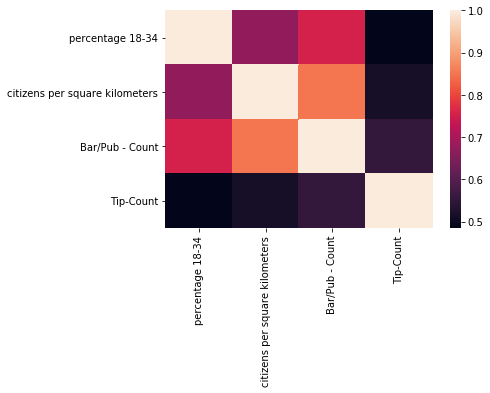

In [107]:
# plotting the heatmap
import seaborn as sns
%matplotlib inline
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Choosing a good Neighborhood

In [108]:
df_merge2.head()

Neighborhood              Venue                        ID Bar/Pub - Type  \
0  Altstadt-S√ºd      Em Tres√É¬∂rche  4e0f859cd22d8582bdc9c18f            Bar   
1  Neustadt-S√ºd  Stereo Wonderland  4b05886af964a52066c422e3            Bar   
2  Neustadt-S√ºd           Acephale  5593146a498ebeb40755d43e            Bar   
3  Neustadt-S√ºd            Zwoeinz  4b50c41cf964a5207e3127e3            Bar   
4  Neustadt-S√ºd        Roter Platz  4bf855be4a67c928453e25cf            Bar   

   percentage 18-34  citizens per square kilometers  Bar/Pub - Count  
0             35.85                         11678.0                1  
1             38.79                         13552.0               14  
2             38.79                         13552.0               14  
3             38.79                         13552.0               14  
4             38.79                         13552.0               14

In [109]:
df_choose = df_merge2.drop(columns=["Venue", 'ID','Bar/Pub - Type'], axis = 1)
df_choose= df_choose.groupby(df_choose["Neighborhood"]).aggregate({'percentage 18-34': 'first', 'citizens per square kilometers': 'first', 'Bar/Pub - Count':'first'})

In [110]:
young = df_choose['percentage 18-34']>=  df_choose.quantile(q=0.7)[0]
dense = df_choose['citizens per square kilometers'] >= df_choose.quantile(q=0.7)[1]
bars = df_choose['Bar/Pub - Count'] >= df_choose.quantile(q=0.7)[2]
df_select = df_choose[young & dense & bars] 

In [111]:
df_select

percentage 18-34  citizens per square kilometers  \
Neighborhood                                                     
Ehrenfeld                35.15                          9759.0   
Neustadt-S√ºd             38.79                         13552.0   

              Bar/Pub - Count  
Neighborhood                   
Ehrenfeld                   9  
Neustadt-S√ºd               14